# MNIST Object Detection

## MNISTを加工した物体検出用データセット

In [1]:
import albumentations as A
from albumentations.pytorch import transforms as AT

from dataloaders.detection_dataset import DetectionMNIST

# 前処理の定義
transform = A.Compose([
    AT.ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_val_set = DetectionMNIST(root='.', threshold=0.2, sigma=1.,
                               transform=transform, fashion=False,
                               train=True, download=False)

len(train_val_set)    # 訓練セットと検証セットを合わせたサイズ

60000

In [2]:
image, bboxes, labels, keypoint, offset, size = train_val_set[2]

image.shape, bboxes.shape, labels.shape, keypoint.shape, offset.shape, size.shape

(torch.Size([1, 28, 28]),
 torch.Size([1, 4]),
 torch.Size([1]),
 torch.Size([10, 7, 7]),
 torch.Size([2, 7, 7]),
 torch.Size([2, 7, 7]))

### 画像とバウンディングボックスの確認

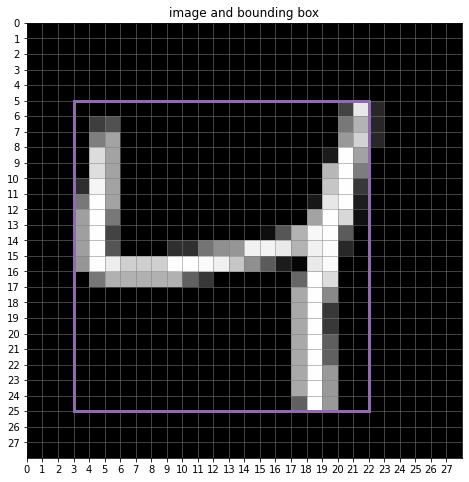

In [3]:
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np

bbox = bboxes[0]    # MNISTは画像中に物体が一つ
label = labels[0]

tab10 = plt.get_cmap('tab10')

fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')

ax.set_xticks(np.arange(0, 28, 1))
ax.set_yticks(np.arange(0, 28, 1))
ax.set_xticklabels(np.arange(0, 28, 1))
ax.set_yticklabels(np.arange(0, 28, 1))
ax.grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)

ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray', extent=[0, 28, 28, 0])

rect = mpatches.Rectangle([bbox[0].item(), bbox[1].item()],
                          (bbox[2]-bbox[0]).item(),
                          (bbox[3]-bbox[1]).item(),
                          fill=False, edgecolor=tab10(label.item()), linewidth=3)
ax.add_patch(rect)
ax.set_title('image and bounding box')

plt.show()

### ターゲットマップの確認

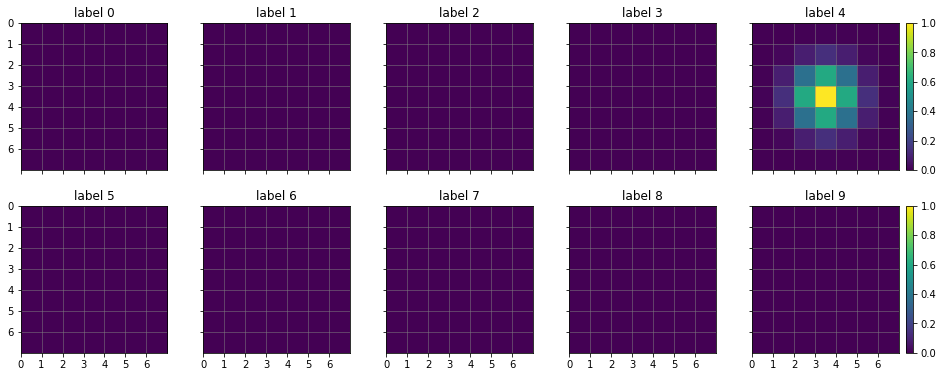

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, figsize=(16, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 5),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(10):
    img = grid[i].imshow(keypoint[i].numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
    grid.cbar_axes[i].colorbar(img)

    grid[i].set_xticks(np.arange(0, 7, 1))
    grid[i].set_yticks(np.arange(0, 7, 1))
    grid[i].set_xticklabels(np.arange(0, 7, 1))
    grid[i].set_yticklabels(np.arange(0, 7, 1))
    grid[i].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
    grid[i].set_title(f'label {i}')

plt.show()

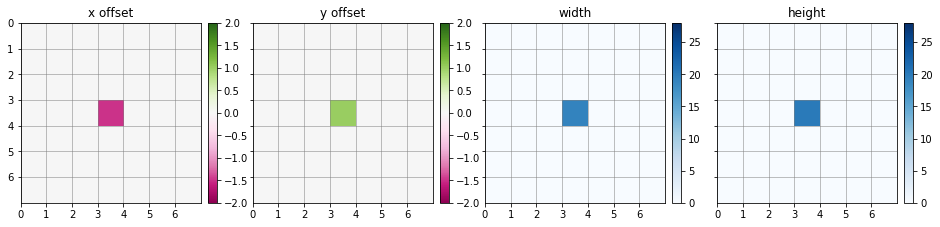

In [5]:
fig = plt.figure(1, figsize=(16, 4), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 4),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='each', cbar_pad=0.1
                 )

img = grid[0].imshow(offset[0].numpy(), vmin=-2, vmax=2, cmap='PiYG', extent=[0, 7, 7, 0])
grid.cbar_axes[0].colorbar(img)
grid[0].set_title('x offset')

img = grid[1].imshow(offset[1].numpy(), vmin=-2, vmax=2, cmap='PiYG', extent=[0, 7, 7, 0])
grid.cbar_axes[1].colorbar(img)
grid[1].set_title('y offset')

img = grid[2].imshow(size[0].numpy(), vmin=0, vmax=28, cmap='Blues', extent=[0, 7, 7, 0])
grid.cbar_axes[2].colorbar(img)
grid[2].set_title('width')

img = grid[3].imshow(size[1].numpy(), vmin=0, vmax=28, cmap='Blues', extent=[0, 7, 7, 0])
grid.cbar_axes[3].colorbar(img)
grid[3].set_title('height')

for i in range(4):
    grid[i].set_xticks(np.arange(0, 7, 1))
    grid[i].set_yticks(np.arange(0, 7, 1))
    grid[i].set_xticklabels(np.arange(0, 7, 1))
    grid[i].set_yticklabels(np.arange(0, 7, 1))
    grid[i].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)

plt.show()

### ターゲットマップからバウンディングボックスの表現

In [6]:
from utils.util import get_peak_indices

_, C_index, H_index, W_index = get_peak_indices(keypoint.unsqueeze(dim=0), k=1)

C_index, H_index, W_index

(tensor([4]), tensor([3]), tensor([3]))

In [7]:
x_center = 4. * (W_index + 0.5).item()
y_center = 4. * (H_index + 0.5).item()

x_center, y_center

(14.0, 14.0)

In [8]:
x_offset = offset[0, H_index, W_index].item()
y_offset = offset[1, H_index, W_index].item()

x_offset, y_offset

(-1.5, 1.0)

In [9]:
width = size[0, H_index, W_index].item()
height = size[1, H_index, W_index].item()

width, height

(19.0, 20.0)

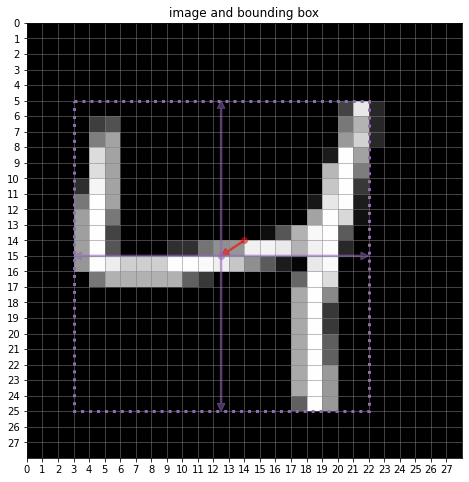

In [10]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')

C_index = C_index.item()

ax.set_xticks(np.arange(0, 28, 1))
ax.set_yticks(np.arange(0, 28, 1))
ax.set_xticklabels(np.arange(0, 28, 1))
ax.set_yticklabels(np.arange(0, 28, 1))
ax.grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)

ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray', extent=[0, 28, 28, 0])

ax.scatter(x_center, y_center, marker='o', color='red', alpha=0.5)

ax.arrow(x=x_center, y=y_center,
         dx=x_offset, dy=y_offset,
         width=0.1, head_width=0.5, head_length=0.5, length_includes_head=True,
         color='red', alpha=0.5)

ax.scatter(x_center+x_offset, y_center+y_offset, marker='o', color=tab10(C_index), alpha=0.5)

ax.arrow(x=x_center+x_offset, y=y_center+y_offset,
         dx=-width/2., dy=0,
         width=0.1, head_width=0.5, head_length=0.5, length_includes_head=True, color=tab10(C_index), alpha=0.5)
ax.arrow(x=x_center+x_offset, y=y_center+y_offset,
         dx=width/2., dy=0,
         width=0.1, head_width=0.5, head_length=0.5, length_includes_head=True, color=tab10(C_index), alpha=0.5)

ax.arrow(x=x_center+x_offset, y=y_center+y_offset,
         dx=0, dy=-height/2.,
         width=0.1, head_width=0.5, head_length=0.5, length_includes_head=True, color=tab10(C_index), alpha=0.5)
ax.arrow(x=x_center+x_offset, y=y_center+y_offset,
         dx=0, dy=height/2.,
         width=0.1, head_width=0.5, head_length=0.5, length_includes_head=True, color=tab10(C_index), alpha=0.5)

rect = mpatches.Rectangle([x_center+x_offset-width/2, y_center+y_offset-height/2],
                          width, height, linestyle=':', fill=False, edgecolor=tab10(C_index), linewidth=3)
ax.add_patch(rect)
ax.set_title('image and bounding box')

plt.show()

## データ拡張の挙動

In [11]:
from torch.utils.data import random_split

# 訓練データセット:検証データセット = 5:1 に分割するサイズ
train_size = len(train_val_set) * 5 // 6
val_size = len(train_val_set) - train_size

# ランダム分割で訓練セットと検証セットを作成
train_set, val_set = random_split(train_val_set, [train_size, val_size])

len(train_set), len(val_set)  # 訓練セットと検証セットのサイズ

(50000, 10000)

In [12]:
# 訓練セットと検証セットの実体は未だ同一オブジェクト
id(train_set.dataset), id(val_set.dataset)

(139803335341488, 139803335341488)

In [13]:
from copy import deepcopy

# データ拡張のために訓練セットのオブジェクトをディープコピーする
train_set.dataset = deepcopy(train_set.dataset)

# 訓練セットと検証セットの実体が異なるオブジェクトになったことを確認
id(train_set.dataset), id(val_set.dataset)

(139797337359408, 139803335341488)

In [14]:
# 訓練セットにランダムアフィン変換のデータ拡張を設定
train_set.dataset.transform = A.Compose([
    A.Affine(scale=(0.85, 1.15), translate_px=(-2, 2), rotate=(-10, 10), shear=(-15, 15), always_apply=True),
    AT.ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

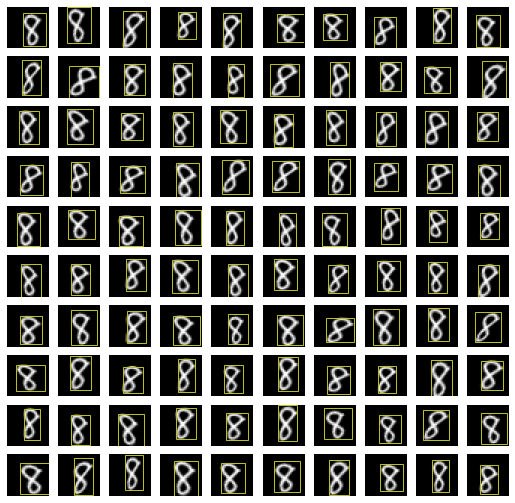

In [15]:
import math

images = []
bboxes_list = []
labels_list = []
for i in range(100):
    image, bboxes, labels, _, _, _ = train_set[0]
    images.append(image)
    bboxes_list.append(bboxes)
    labels_list.append(labels)

fig = plt.figure(figsize=(9, 9), facecolor='white')
tab10 = plt.get_cmap('tab10')
nrows = 10
ncols = math.ceil(len(images) / nrows)

for i, (image, bboxes, labels) in enumerate(zip(images, bboxes_list, labels_list)):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis('off')

    ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray', extent=[0, 28, 28, 0])

    for bbox, label in zip(bboxes, labels):    
        rect = mpatches.Rectangle([bbox[0].item(), bbox[1].item()],
                                (bbox[2]-bbox[0]).item(),
                                (bbox[3]-bbox[1]).item(),
                                fill=False, edgecolor=tab10(label.item()), linewidth=1)
        ax.add_patch(rect)

plt.show()

## DetaLoaderでの挙動

In [16]:
import torch
from torch.utils.data import DataLoader

# ボックスとラベルはリストのまま、他は連結して一つのTensorにする関数
def collate_fn(batch):
    images, bboxes, labels, keypoints, offsets, sizes = zip(*batch)
    return torch.stack(images, dim=0), bboxes, labels, \
        torch.stack(keypoints, dim=0), torch.stack(offsets, dim=0), torch.stack(sizes, dim=0)

batch_size = 100    # ミニバッチサイズは100

# 訓練データローダーと検証データローダーを作成
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

len(train_loader), len(val_loader)     # ミニバッチの個数

(500, 100)

In [17]:
data = next(iter(train_loader))  # 訓練ローダーの最初の1ミニバッチ
images, bboxes_list, labels_list, keypoints, offsets, sizes = data

images.shape, len(bboxes_list), len(labels_list), keypoints.shape, offsets.shape, sizes.shape

(torch.Size([100, 1, 28, 28]),
 100,
 100,
 torch.Size([100, 10, 7, 7]),
 torch.Size([100, 2, 7, 7]),
 torch.Size([100, 2, 7, 7]))

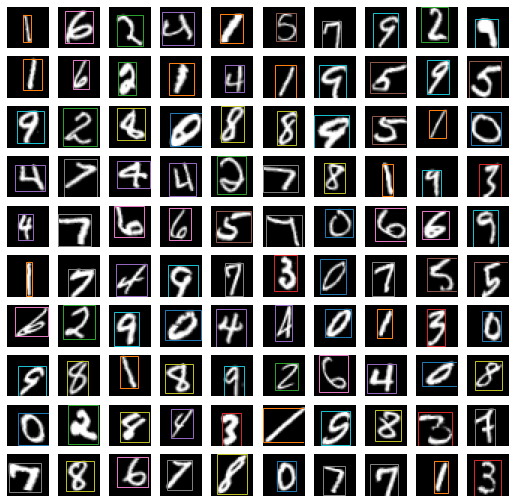

In [18]:
fig = plt.figure(figsize=(9, 9), facecolor='white')
tab10 = plt.get_cmap('tab10')
nrows = 10
ncols = math.ceil(len(images) / nrows)

for i, (image, bboxes, labels) in enumerate(zip(images, bboxes_list, labels_list)):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis('off')

    ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray', extent=[0, 28, 28, 0])

    for bbox, label in zip(bboxes, labels):
        rect = mpatches.Rectangle([bbox[0].item(), bbox[1].item()],
                                (bbox[2]-bbox[0]).item(),
                                (bbox[3]-bbox[1]).item(),
                                fill=False, edgecolor=tab10(label.item()), linewidth=1)
        ax.add_patch(rect)

plt.show()

## 物体検出用ネットワークの設定

In [19]:
from models.simple_pointnet import SimplePointNet

in_channels = 1
num_classes = 10

net = SimplePointNet(in_channels, num_classes)

In [20]:
import torch

# 学習に使用するデバイスの設定。CPU or GPU、GPUが使用できない場合は自動的にCPU設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [21]:
# ニューラルネットワークをデバイスに送る。デバイスがCPUの場合は実質変更なし
net.to(device)

SimplePointNet(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  )
  (keypoint_head): Seque

## 損失関数、評価関数、最適化アルゴリズムの設定

In [22]:
from torch import optim

from criteria.pointnet_loss import PointNetLoss
from metrics.detection_metric import BboxScoring

# 損失関数の設定
criterion = PointNetLoss()

# 評価関数の設定
metric = BboxScoring(iou_threshold=0.75)

# 最適化アルゴリズムの設定
learning_rate = 1e-3     # 学習率
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## 学習の実行

In [23]:
import os
from routines.detection_routine import run_detection

max_epoch = 20     # データセットを学習する回数

# 保存先の作成
os.makedirs('results/mnist_detection', exist_ok=True)

for epoch in range(1, max_epoch+1):
    # 訓練実行
    run_detection('train', epoch, train_loader, device, net, criterion, metric, optimizer=optimizer)
    
    # 検証実行
    run_detection('val', epoch, val_loader, device, net, criterion, metric)

# 学習したニューラルネットワークのパラメータを保存
net.to('cpu')
torch.save(net.state_dict(), f'results/mnist_detection/model_epoch{epoch}.pth')

train [mini-batches: 50, images: 5000] loss: 15.0167
train [mini-batches: 100, images: 10000] loss: 10.4466
train [mini-batches: 150, images: 15000] loss: 9.0037
train [mini-batches: 200, images: 20000] loss: 8.2867
train [mini-batches: 250, images: 25000] loss: 7.7255
train [mini-batches: 300, images: 30000] loss: 7.3984
train [mini-batches: 350, images: 35000] loss: 7.3425
train [mini-batches: 400, images: 40000] loss: 7.1370
train [mini-batches: 450, images: 45000] loss: 7.0549
train [mini-batches: 500, images: 50000] loss: 6.8587
Epoch: 1/train  loss: 12.0918  TP: 30568  FP: 8799  FN: 19432

val [mini-batches: 10, images: 1000] loss: 6.9925
val [mini-batches: 20, images: 2000] loss: 6.8572
val [mini-batches: 30, images: 3000] loss: 6.7556
val [mini-batches: 40, images: 4000] loss: 6.7449
val [mini-batches: 50, images: 5000] loss: 6.7105
val [mini-batches: 60, images: 6000] loss: 6.9584
val [mini-batches: 70, images: 7000] loss: 6.9059
val [mini-batches: 80, images: 8000] loss: 6.55

## 推論の実行

In [24]:
net.load_state_dict(torch.load('results/mnist_detection/model_epoch20.pth'))
net.to(device)

SimplePointNet(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  )
  (keypoint_head): Seque

In [25]:
transform = A.Compose([
    AT.ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# テストセットの設定
test_set = DetectionMNIST(root='.', threshold=0.2, sigma=1., fashion=False,
                          train=False, download=False, transform=transform)

# テストローダーの設定
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [26]:
# テスト実行
run_detection('test', None, test_loader, device, net, criterion, metric)

test [mini-batches: 10, images: 1000] loss: 6.1826
test [mini-batches: 20, images: 2000] loss: 6.1595
test [mini-batches: 30, images: 3000] loss: 6.0224
test [mini-batches: 40, images: 4000] loss: 6.0425
test [mini-batches: 50, images: 5000] loss: 5.8832
test [mini-batches: 60, images: 6000] loss: 5.9157
test [mini-batches: 70, images: 7000] loss: 5.9226
test [mini-batches: 80, images: 8000] loss: 6.1743
test [mini-batches: 90, images: 9000] loss: 5.9199
test [mini-batches: 100, images: 10000] loss: 5.8138
test  loss: 5.9917  TP: 9825  FP: 178  FN: 175



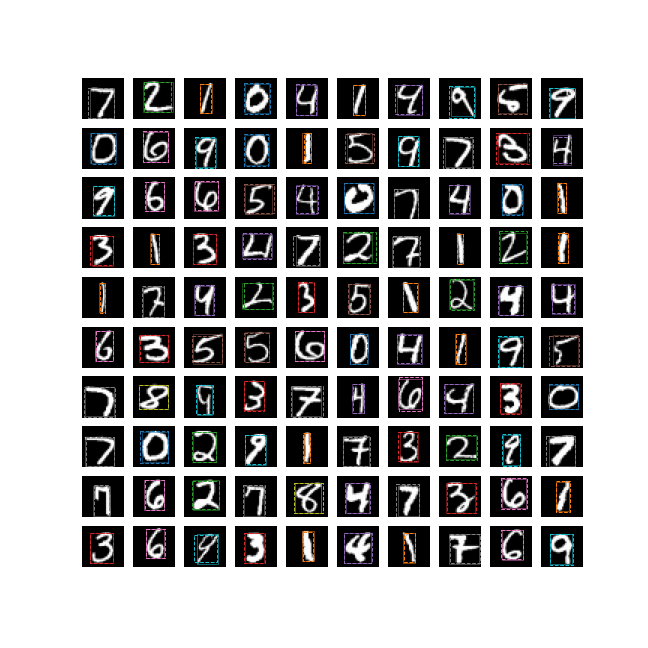

In [27]:
from PIL import Image

# 薄い実線が正解、点線が推論のボックスになっている
Image.open('results/mnist_detection/test.png')

## 補足：ピークの検出方法

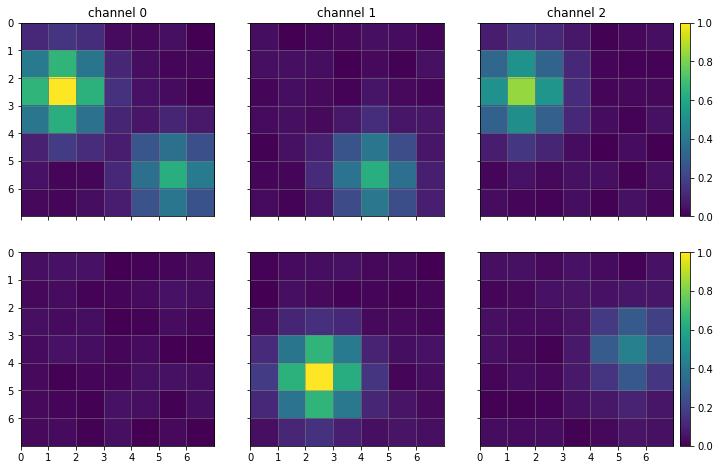

In [28]:
N = 2   # ミニバッチサイズ2
C = 3   # チャネル数3
H = 7
W = 7

# 説明のためのサンプルピークマップ
sample_keypoints = torch.zeros([N, C, H, W], dtype=torch.float32)

class Gaussian:
    def __init__(self, sigma):
        self.sigma = sigma
        self.grid_y, self.grid_x = torch.meshgrid(torch.arange(7), torch.arange(7), indexing='ij')
    
    def __call__(self, y, x):
        return torch.exp(-((self.grid_y - y)**2 + (self.grid_x - x)**2) / (2 * self.sigma**2))

gaussian = Gaussian(sigma=1.)

# N=0
sample_keypoints[0, 0] += gaussian(2, 1)
sample_keypoints[0, 0] += 0.6 * gaussian(5, 5)
sample_keypoints[0, 2] += 0.8 * gaussian(2, 1)
sample_keypoints[0, 1] += 0.6 * gaussian(5, 4)

# N=1
sample_keypoints[1, 1] += gaussian(4, 2)
sample_keypoints[1, 2] += 0.4 * gaussian(3, 5)

# ノイズ
sample_keypoints += 0.05 * torch.rand([2, 3, 7, 7])

sample_keypoints = torch.clamp(sample_keypoints, 0., 1.)

fig = plt.figure(1, figsize=(12, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(2):
    for j in range(3):
        img = grid[3*i+j].imshow(sample_keypoints[i, j].numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
        grid.cbar_axes[3*i+j].colorbar(img)
        grid[3*i+j].set_xticks(np.arange(0, 7, 1))
        grid[3*i+j].set_yticks(np.arange(0, 7, 1))
        grid[3*i+j].set_xticklabels(np.arange(0, 7, 1))
        grid[3*i+j].set_yticklabels(np.arange(0, 7, 1))
        grid[3*i+j].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
        if i == 0:
            grid[j].set_title(f'channel {j}')

plt.show()

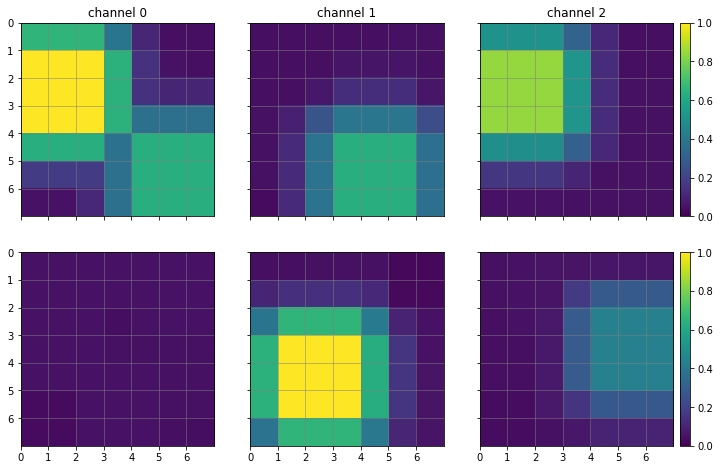

In [29]:
from torch.nn import functional as F

# チャネル別に3x3のモルフォロジー膨張演算を行う
# 膨張演算はMaxPoolingでkernel=3、stride=1にしたときに等しい
dilation = F.max_pool2d(sample_keypoints, 3, stride=1, padding=1)  

fig = plt.figure(1, figsize=(12, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(2):
    for j in range(3):
        img = grid[3*i+j].imshow(dilation[i, j].numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
        grid.cbar_axes[3*i+j].colorbar(img)
        grid[3*i+j].set_xticks(np.arange(0, 7, 1))
        grid[3*i+j].set_yticks(np.arange(0, 7, 1))
        grid[3*i+j].set_xticklabels(np.arange(0, 7, 1))
        grid[3*i+j].set_yticklabels(np.arange(0, 7, 1))
        grid[3*i+j].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
        if i == 0:
            grid[j].set_title(f'channel {j}')

plt.show()

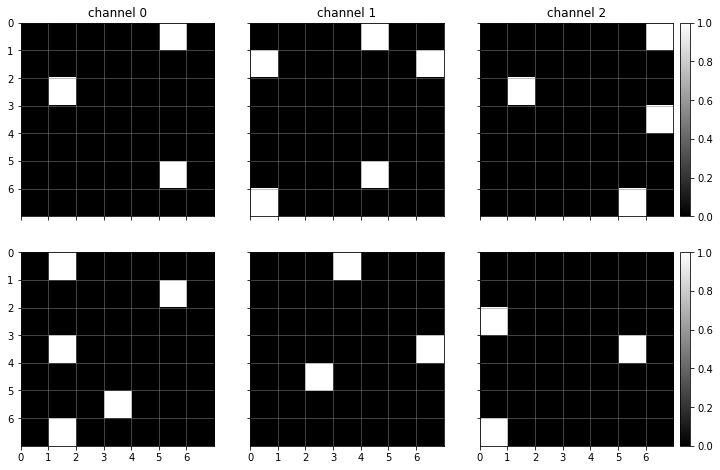

In [30]:
# 3x3範囲の最大値に等しい位置がTrueのマスクを作成する
spatial_mask = (dilation == sample_keypoints)

fig = plt.figure(1, figsize=(12, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(2):
    for j in range(3):
        img = grid[3*i+j].imshow(spatial_mask[i, j].numpy(), cmap='gray', vmin=0, vmax=1, extent=[0, 7, 7, 0])
        grid.cbar_axes[3*i+j].colorbar(img)
        grid[3*i+j].set_xticks(np.arange(0, 7, 1))
        grid[3*i+j].set_yticks(np.arange(0, 7, 1))
        grid[3*i+j].set_xticklabels(np.arange(0, 7, 1))
        grid[3*i+j].set_yticklabels(np.arange(0, 7, 1))
        grid[3*i+j].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
        if i == 0:
            grid[j].set_title(f'channel {j}')

plt.show()

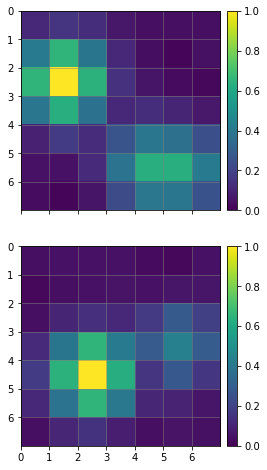

In [31]:
# 各ピクセルでチャネル方向の最大値を求める
channel_max = torch.max(sample_keypoints, dim=1, keepdim=True)[0]

fig = plt.figure(1, figsize=(12, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 1),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(2):
    img = grid[i].imshow(channel_max[i].squeeze(dim=0).numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
    grid.cbar_axes[i].colorbar(img)
    grid[i].set_xticks(np.arange(0, 7, 1))
    grid[i].set_yticks(np.arange(0, 7, 1))
    grid[i].set_xticklabels(np.arange(0, 7, 1))
    grid[i].set_yticklabels(np.arange(0, 7, 1))
    grid[i].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)

plt.show()

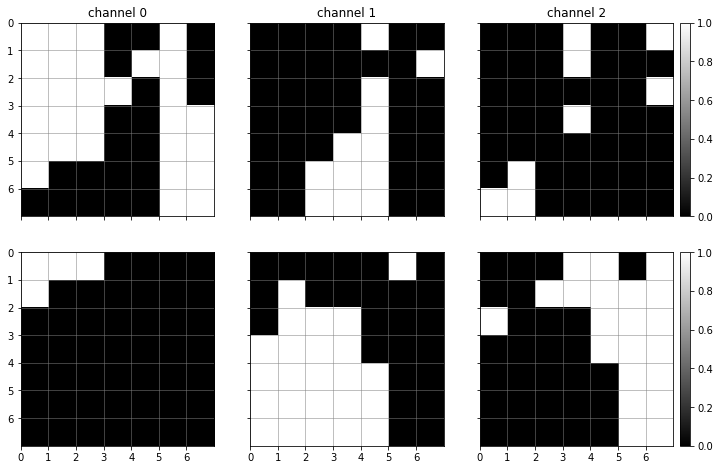

In [32]:
# チャネル方向最大値に等しい位置がTrueのマスクを作成する
channel_mask = (channel_max == sample_keypoints)  

fig = plt.figure(1, figsize=(12, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(2):
    for j in range(3):
        img = grid[3*i+j].imshow(channel_mask[i, j].numpy(), cmap='gray', vmin=0, vmax=1, extent=[0, 7, 7, 0])
        grid.cbar_axes[3*i+j].colorbar(img)
        grid[3*i+j].set_xticks(np.arange(0, 7, 1))
        grid[3*i+j].set_yticks(np.arange(0, 7, 1))
        grid[3*i+j].set_xticklabels(np.arange(0, 7, 1))
        grid[3*i+j].set_yticklabels(np.arange(0, 7, 1))
        grid[3*i+j].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
        if i == 0:
            grid[j].set_title(f'channel {j}')

plt.show()

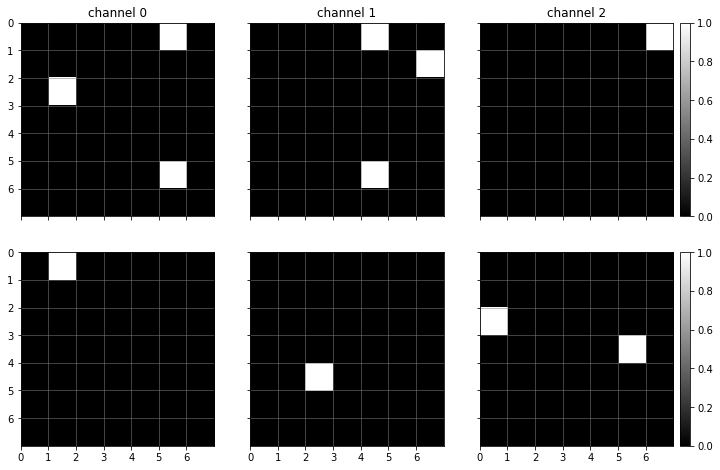

In [33]:
# 空間のマスクとチャネルのマスクがそれぞれTrueの箇所がピーク位置
max_mask = spatial_mask * channel_mask

fig = plt.figure(1, figsize=(12, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(2):
    for j in range(3):
        img = grid[3*i+j].imshow(max_mask[i, j].numpy(), cmap='gray', vmin=0, vmax=1, extent=[0, 7, 7, 0])
        grid.cbar_axes[3*i+j].colorbar(img)
        grid[3*i+j].set_xticks(np.arange(0, 7, 1))
        grid[3*i+j].set_yticks(np.arange(0, 7, 1))
        grid[3*i+j].set_xticklabels(np.arange(0, 7, 1))
        grid[3*i+j].set_yticklabels(np.arange(0, 7, 1))
        grid[3*i+j].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
        if i == 0:
            grid[j].set_title(f'channel {j}')

plt.show()

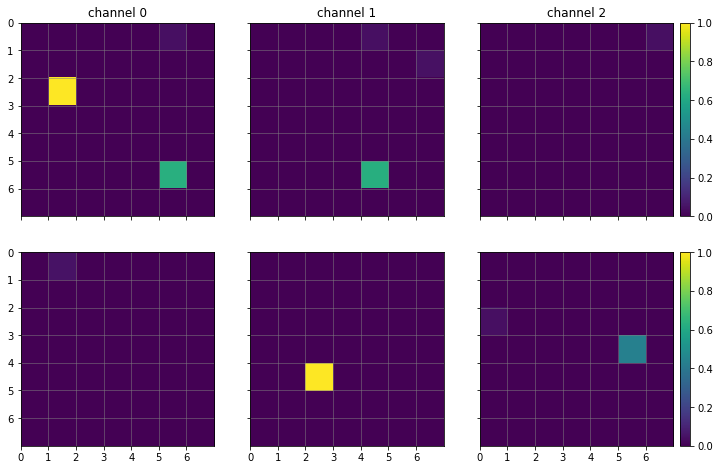

In [34]:
# ノイズで正しいピーク位置以外も検出してしまうため、キーポイントマップを乗算する
# これで真のピーク位置のみ強い値をとる
peak = max_mask * sample_keypoints

fig = plt.figure(1, figsize=(12, 8), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 3),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

for i in range(2):
    for j in range(3):
        img = grid[3*i+j].imshow(peak[i, j].numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
        grid.cbar_axes[3*i+j].colorbar(img)
        grid[3*i+j].set_xticks(np.arange(0, 7, 1))
        grid[3*i+j].set_yticks(np.arange(0, 7, 1))
        grid[3*i+j].set_xticklabels(np.arange(0, 7, 1))
        grid[3*i+j].set_yticklabels(np.arange(0, 7, 1))
        grid[3*i+j].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)
        if i == 0:
            grid[j].set_title(f'channel {j}')

plt.show()

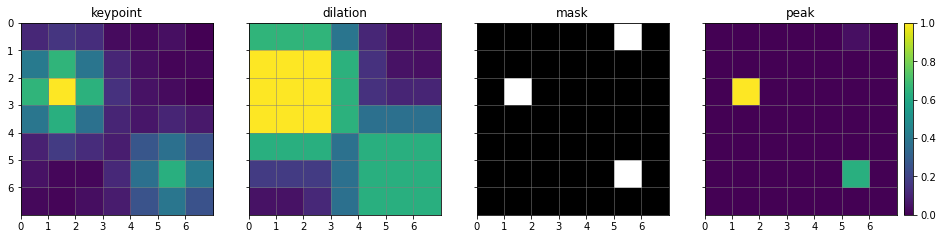

In [35]:
# まとめ
fig = plt.figure(1, figsize=(16, 4), facecolor='white')
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 4),
                 axes_pad=0.5,
                 cbar_location='right', cbar_mode='edge', cbar_pad=0.1
                 )

img = grid[0].imshow(sample_keypoints[0, 0].numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
grid[0].set_title(f'keypoint')

img = grid[1].imshow(dilation[0, 0].numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
grid[1].set_title(f'dilation')

img = grid[2].imshow(max_mask[0, 0].numpy(), cmap='gray', vmin=0, vmax=1, extent=[0, 7, 7, 0])
grid[2].set_title(f'mask')

img = grid[3].imshow(peak[0, 0].numpy(), vmin=0, vmax=1, extent=[0, 7, 7, 0])
grid[3].set_title(f'peak')

for i in range(4):
    grid.cbar_axes[i].colorbar(img)
    grid[i].set_xticks(np.arange(0, 7, 1))
    grid[i].set_yticks(np.arange(0, 7, 1))
    grid[i].set_xticklabels(np.arange(0, 7, 1))
    grid[i].set_yticklabels(np.arange(0, 7, 1))
    grid[i].grid(color='gray', alpha=0.5, linestyle='-', linewidth=1)

plt.show()